In [1]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import pathlib

In [2]:
base_dir = pathlib.Path().resolve()
datasets_path = f'{base_dir}/Dataset'
users_df = pd.read_csv(f'{datasets_path}/users.csv')
print(users_df.shape)
all_ratings_df = pd.read_csv(f'{datasets_path}/ratings_v2_numberOfMore3RateForEachUser50to400.csv')
print(all_ratings_df.shape)
# filtered_ratings_df = pd.read_csv(f'{datasets_path}/ratings_v3_numberOfRateForEachUser50to400_and_RatingMore3.csv')
# print(filtered_ratings_df.shape)

(69840, 1)
(9948371, 3)


In [3]:
all_ratings_df.groupby(['rating'])['rating'].count()

rating
0.5     131528
1.0     222606
1.5     146523
2.0     527298
2.5     480446
3.0    1635886
3.5    1343258
4.0    2723141
4.5    1119853
5.0    1617832
Name: rating, dtype: int64

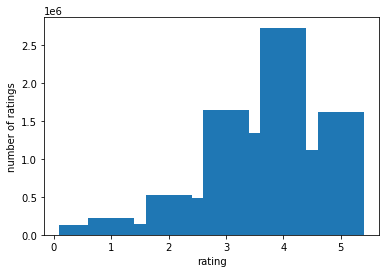

In [4]:
plt.bar([i*0.5 for i in range(1, 11)], np.array(all_ratings_df.groupby(['rating'])['rating'].count()))
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

In [5]:
movies_df = pd.read_csv(f'{datasets_path}/movies.csv')
print(movies_df.shape)
genres_title_list = []
for row in movies_df.values:
    genres = row[2].split("|")
    for genre in genres:
        if genre not in genres_title_list:
            genres_title_list.append(genre)
print(len(genres_title_list))

def find_genres_columns(current_genres, genres_title_list):
    temp_list = []
    for genre in genres_title_list:
        if genre in current_genres:
            temp_list.append(1)
        else:
            temp_list.append(0)
    temp_list = np.array(temp_list)
    return temp_list

temp = movies_df.copy(deep=True)
year_list = []
name_list = []
genres_list = []
for row in temp.values:
    id = row[0]
    name = str(row[1]).strip()
    name_inx = str(name).find('(')
    year = name[-5:-1]
    try:
        year = int(year)
    except Exception as e:
        year = -1
    genres = row[2].split('|')
    genres = find_genres_columns(genres, genres_title_list)
    genres_list.append(genres)
    name = name[:name_inx-1].replace('(', '').replace(')', '')
    year_list.append(year)
    name_list.append(name)
genres_list = np.array(genres_list)
year_list = np.array(year_list)
name_list = np.array(name_list)
temp['title'] = name_list
temp['year'] = year_list
temp['genres'] = list(genres_list)
for i, genre in enumerate(genres_title_list):
    temp[genre] = genres_list[:, i]

temp = temp[temp['(no genres listed)'] == 0]
del temp['(no genres listed)']
temp.head()
movies_df = temp
del movies_df['genres']

(1318, 3)
19


In [89]:
# Converting float userIds and movieIds to integers
user_id_list = []
movie_id_list = []
for row in all_ratings_df.values:
    user_id = int(row[0])
    movie_id = int(row[1])
    user_id_list.append(user_id)
    movie_id_list.append(movie_id)
all_ratings_df['movieId'] = movie_id_list
all_ratings_df['userId'] = user_id_list
all_ratings_df

,userId,movieId,rating
0,4,114709,4.0
1,4,113497,4.0
2,4,113277,4.5
3,4,113189,4.0
4,4,112641,4.0
...,...,...,...
9948366,283224,99423,3.0
9948367,283224,103776,3.0
9948368,283224,105690,4.0
9948369,283224,73195,5.0


In [1]:
users_dict = dict()
count = 0
for row in users_df.values:
    user = row[0]
    users_dict[user] = count
    count+=1
print(users_df.shape)
users_features = np.zeros((users_df.shape[0], 1), dtype=np.int64)
# users_features = np.zeros((users_df.shape[0], 1))
users_features = torch.from_numpy(users_features)
users_features

NameError: name 'users_df' is not defined

In [90]:
# creating dictionaries for movies
movie_dict = dict()
movie_name_dict = dict()
count = 0
movies_features = []
for row in movies_df.values:
    movie_dict[row[0]] = count
    movie_name_dict[row[1]] = row[1]
    count+=1
    movies_features.append(np.array(row[3:]))
movies_features =np.array(movies_features, dtype=np.int64)
print(movies_features.shape)
movies_features = torch.from_numpy(movies_features)
movies_features

(1317, 18)


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [96]:
all_ratings_df

,userId,movieId,rating
0,4,114709,4.0
1,4,113497,4.0
2,4,113277,4.5
3,4,113189,4.0
4,4,112641,4.0
...,...,...,...
9948366,283224,99423,3.0
9948367,283224,103776,3.0
9948368,283224,105690,4.0
9948369,283224,73195,5.0


In [101]:
all_edges = []
all_edges_attrs = []
for row in all_ratings_df.values:
    user = int(row[0])
    movie = int(row[1])
    rating = float(row[2])
    try:
        all_edges.append([users_dict[user], movie_dict[movie]])
        all_edges_attrs.append(rating)
    except Exception as e:
        pass

In [107]:
all_edges = np.array(all_edges)
edge_index = torch.from_numpy(all_edges)
edge_index = edge_index.T

In [133]:
all_edges_attrs = np.array(all_edges_attrs, dtype=np.float16)
edge_attr = torch.from_numpy(all_edges_attrs)
edge_attr

tensor([4.0000, 4.0000, 4.5000,  ..., 4.0000, 5.0000, 5.0000],
       dtype=torch.float16)

In [134]:
movies_features, users_features, edge_index, edge_attr

(tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]),
 tensor([[    0,     0,     0,  ..., 69839, 69839, 69839],
         [    0,     1,     2,  ...,   238,   239,   312]]),
 tensor([4.0000, 4.0000, 4.5000,  ..., 4.0000, 5.0000, 5.0000],
        dtype=torch.float16))

### remember that movies with no genres are deleted (in our case only one movie is deleted)

## remember to run your model once as directed and once as undirected graphs

In [71]:
import torch_geometric.transforms as T

# data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)
# data = T.NormalizeFeatures()(data)

In [215]:
u_f = users_features
m_f = movies_features
e_i = edge_index
e_a = edge_attr.long()

In [216]:
from torch_geometric.data import HeteroData
data = HeteroData()

# data['user'].x = users_features
# data['movie'].x = movies_features
# data['user', 'rate', 'movie'].edge_index = edge_index
# data['user', 'rate', 'movie'].edge_attr = edge_attr

data['user'].x = u_f
data['movie'].x = m_f
data['user', 'rate', 'movie'].edge_index = e_i
data['user', 'rate', 'movie'].edge_attr = e_a

In [3]:
del data

NameError: name 'data' is not defined

In [218]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GNN(hidden_channels=64, out_channels=128)
model = to_hetero(model, data.metadata(), aggr='sum')

In [219]:
print(edge_index.dtype)
print(edge_attr.dtype)
print(users_features.dtype)
print(movies_features.dtype)

torch.int64
torch.float16
torch.int64
torch.int64


In [210]:
import torch_geometric.transforms as T
transform = T.RandomNodeSplit()
data2 = transform(data)

In [211]:
data2

HeteroData(
  user={ x=[69840, 1] },
  movie={ x=[1317, 18] },
  (user, rate, movie)={
    edge_index=[2, 9948244],
    edge_attr=[9948244]
  }
)

## training in full batch mode

In [221]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
def train():
    model.train()
    optimizer.zero_grad()
    # out = model(data.x_dict, data.edge_index_dict)
    # out = model(data.xd, data.edge_index_dict)
    out = model(data2.x_dict, data2.edge_index_dict)
    # mask = data['paper'].train_mask
    loss = F.cross_entropy(out['movie'], data2['movie'].y)
    loss.backward()
    optimizer.step()
    return float(loss)

for epoch in range(1, 3+1):
    loss = train()
    print(loss.item())

RuntimeError: expected scalar type Float but found Long

## training in mini batch mode

In [61]:
# Performing neighbor sampling using NeighborLoader
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader

# transform = T.ToUndirected()  # Add reverse edge types.

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "user":
    batch_size=128,
    input_nodes=('user', data['user']),
)

batch = next(iter(train_loader))

RuntimeError: expected scalar type Long but found Int

In [62]:
data

HeteroData(
  user={ x=[69840, 1] },
  movie={ x=[1317, 18] },
  (user, rate, movie)={
    edge_index=[2, 9948244],
    edge_attr=[9948244, 1]
  }
)

In [66]:
data['user'], data['movie']

({'x': tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]], dtype=torch.int32)},
 {'x': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)},
 {})